## Import Packages

In [15]:
# imports
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

from worldllm_envs.playground.playground_text_wrapper import PlayGroundText

## Load the data

In [16]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data

test_trajectories = PlayGroundText.get_test_dataset()
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.text):
        if incr % 2 ==0 and incr != 0:
            test_observations.append(observation)
nb_transitions = len(test_observations)

#Load performance without rules
with open("./outputs/norule/2024-09-26/14-14-22_60/all.json", "r") as f:
    norule_data = json.load(f)
    norule_likelihood_lst = norule_data["metrics"]["test_likelihoods"]
    norule_transition_likelihood_lst = []
    for lst_trajectory_likelihood in norule_data["metrics"]["test_transition_scores"]:
        norule_transition_likelihood_lst.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])


In [17]:
# Load the data
shared_extension = ""
baselines_to_load = [
    "test_pipeline"
]
baselines_names = ["P LL"]
assert len(baselines_to_load) == len(baselines_names)
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_best_rules = {}
all_best_likelihoods = {}
all_best_transition_ll = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "./outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            lst_dir = sorted(os.listdir(path_start + f_day))
            for f_hour in lst_dir:
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        raise NotImplementedError("IS is not supported anymore")
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_best_rules = []
        reshaped_best_likelihood = []
        reshaped_best_transition_ll = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            nb_particles = data["metrics"]["nb_rules"]
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            best_rules = np.array(data["metrics"]["best_rule"])
            best_rule_test_ll = np.array(data["metrics"]["test_likelihoods_best"])
            best_rule_test_transition_ll = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores_best"]:
                best_rule_test_transition_ll.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_best_rules.append(best_rules.reshape((-1, nb_particles)).transpose())
            reshaped_best_likelihood.append(best_rule_test_ll.reshape((-1, nb_particles)).transpose())
            reshaped_best_transition_ll.append(
                np.array(best_rule_test_transition_ll).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_best_rules[b_name] = np.concatenate(reshaped_best_rules, axis=0)
        all_best_likelihoods[b_name] = np.concatenate(reshaped_best_likelihood, axis=0)
        all_best_transition_ll[b_name] = np.concatenate(reshaped_best_transition_ll, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load test_pipeline --------------------------------
Loaded: ./outputs/test_pipeline/2024-10-15/14-11-00_60/all.json


In [18]:
dict_index_transition = {"standing": [], "holding1": [], "holding2": [], "transformP": [], "transformSH": [], "transformBH": [], "nothing": []}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["standing"].append(incr)
    elif "holding" in transition:
        if " and " in transition:
            dict_index_transition["holding2"].append(incr)
        else:
            dict_index_transition["holding1"].append(incr)
    elif "transform" in transition:
        if "into the carrot" in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["transformP"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["transformSH"].append(incr)
        elif "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["transformBH"].append(incr)
        else:
            raise ValueError("Unknown transform")
    elif "Nothing" in transition:
        dict_index_transition["nothing"].append(incr)
    else:
        raise ValueError("Unknown transition")

In [19]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

standing 51
holding1 15
holding2 11
transformP 13
transformSH 3
transformBH 3
nothing 21


## Rules generated

In [20]:
# Best kept rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    best_rules_ind = np.argsort(-all_best_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_best_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_best_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'P LL' Color: Red
-----rule-----:0: "1. Items can be moved around freely.\n2. You can pick up items.\n3. You can put down items.\n\nRules:\na. Moving to what is directly on the ground doesn't physically change its location (like going to the water).\nb. Holding an item if you pick it up but still being on the same object.\nc. Picking up an item transforms it into something else.\nd. Dropping an item onto the ground turns it back into its original form.\ne. Picking up and holding an item as you move to different locations.\nf. A function to check if an item transforms into the opposite item when both are held.\ng. Items can inhabit one another's location while held.\nh. Putting down an item turns it back to the ground.\ni. Stacking items on top of each other.", likelihood: -376.616180
-----rule-----:1: 'a. Items can be moved freely.\nb. Picking up an item does not change its location.\nc. Picking up an item transforms it.\nd. Dropping an item turns i

In [21]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for P LL: [0]


## Comparison across seeds

In [22]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_best_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_best_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_best_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

## Comparaison collecte de données

In [23]:
for transi_type, value in dict_index_transition.items():
    print(transi_type +": "+ str(len(value)))

standing: 51
holding1: 15
holding2: 11
transformP: 13
transformSH: 3
transformBH: 3
nothing: 21


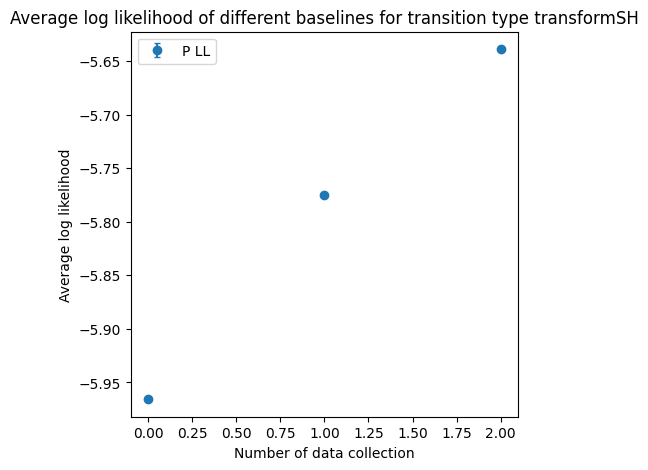

In [24]:
nb_rule_per_collect = 20
transi_type = "transformSH"
plt.figure(figsize=(5,5))
for incr,b_name in enumerate(all_baselines_name):
    # Get the best rules for each particle and data collection for each traj type
    _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
    
    #Add no rule as first collect:
    _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
    _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
    _ll_per_transition = np.concatenate((_norule_likelihood_transition[:,None], _ll_per_transition), axis=1)
    #Plot
    plt.errorbar(np.arange(_ll_per_transition.shape[1])+ incr*0.05, _ll_per_transition.mean(axis=0), yerr=_ll_per_transition.std(axis=0), label=b_name, capsize=2, fmt='o')
    
plt.legend()
plt.xlabel("Number of data collection")
plt.ylabel("Average log likelihood")
plt.title(f"Average log likelihood of different baselines for transition type {transi_type}")
plt.show()

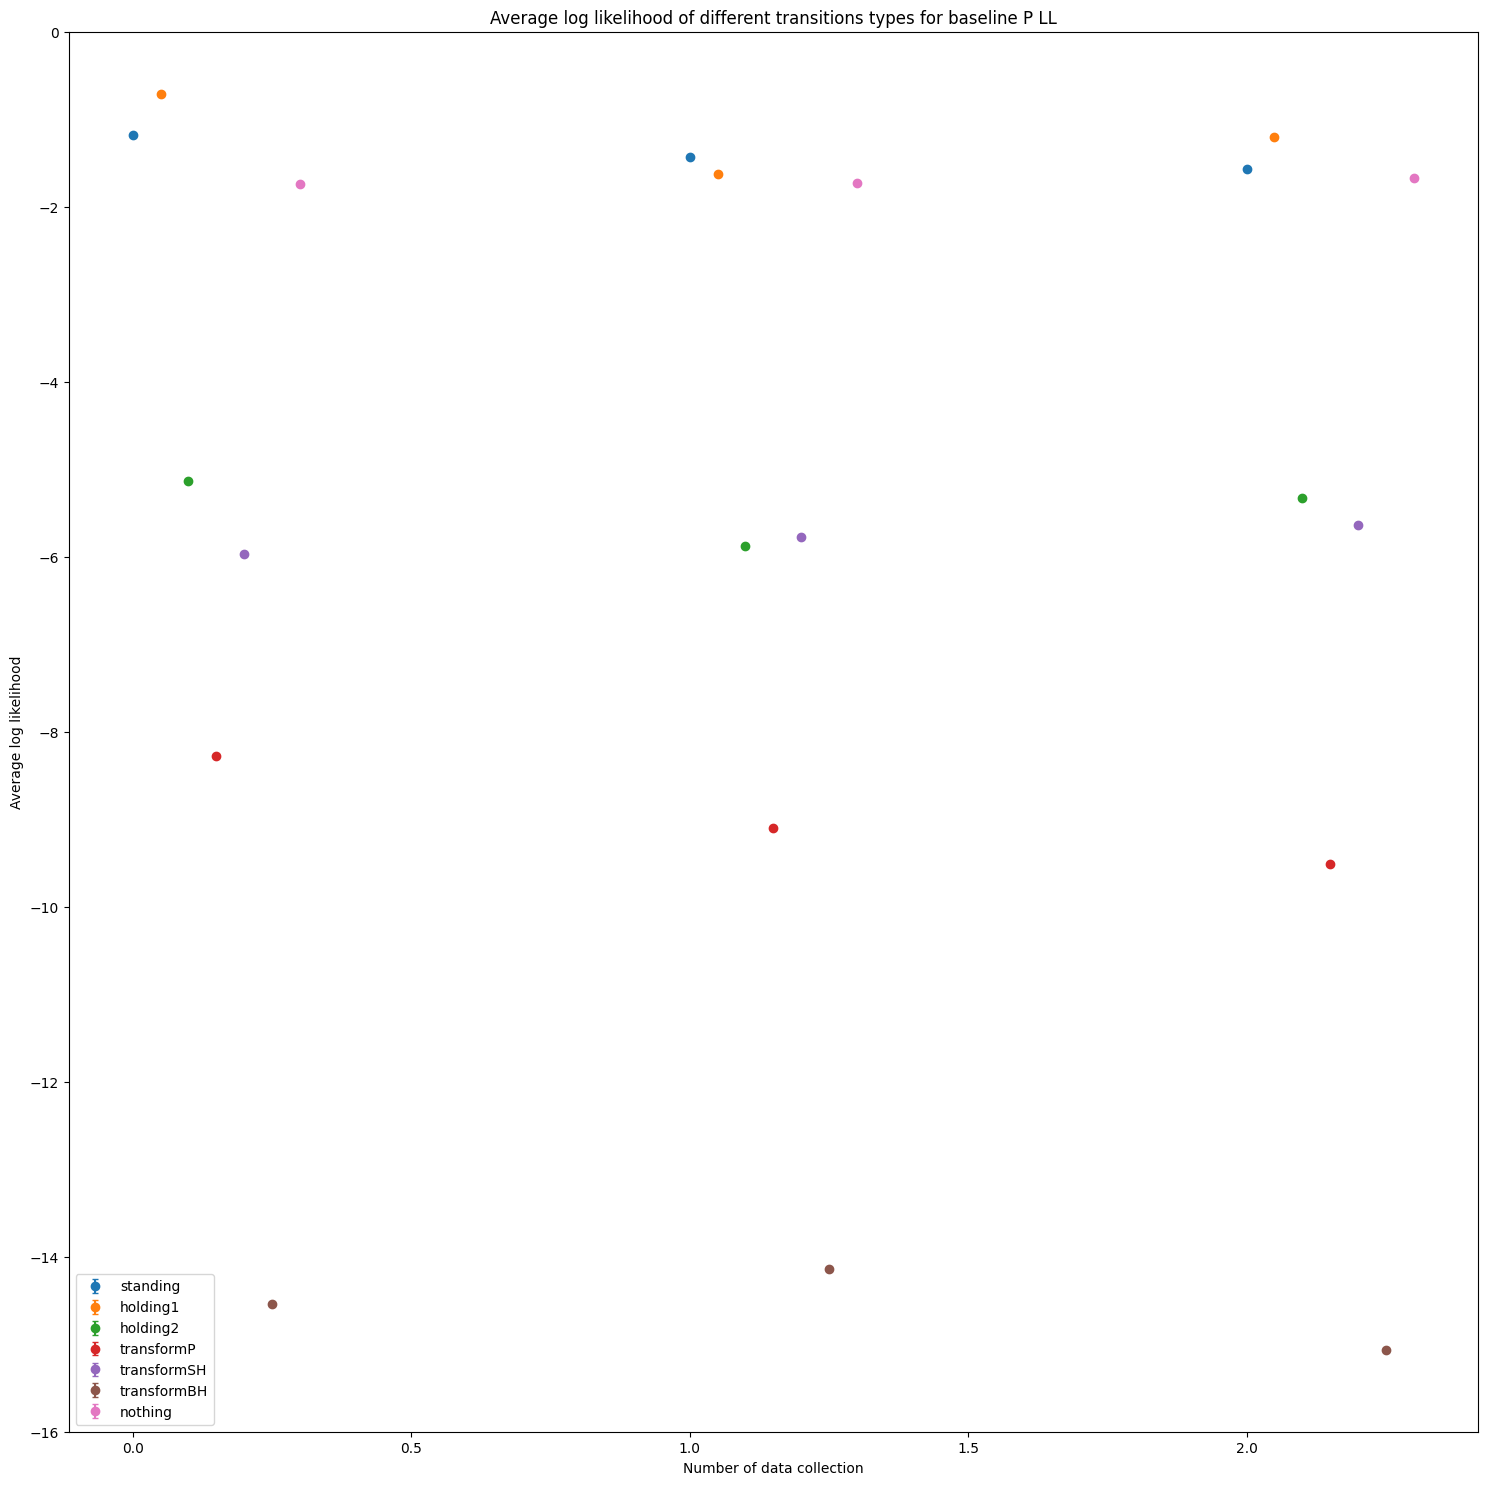

In [25]:
plt.figure(figsize=(40,40))
plt.subplot(2,2,1)
for incr_m, b_name in enumerate(all_baselines_name):
    plt.subplot(2,2,incr_m+1)
    for incr, transi_type in enumerate(dict_index_transition):
        # Get the best rules for each particle and data collection for each traj type
        _ll_per_transition = all_best_transition_ll[b_name][:,:,dict_index_transition[transi_type]].mean(axis=-1)
        
        #Add no rule as first collect:
        _norule_likelihood_transition = np.array(norule_transition_likelihood_lst)[:,dict_index_transition[transi_type]].mean(axis=-1)
        _norule_likelihood_transition = np.repeat(_norule_likelihood_transition, _ll_per_transition.shape[0], axis=0)
        _ll_per_transition = np.concatenate((_norule_likelihood_transition[:,None], _ll_per_transition), axis=1)
        #Plot
        plt.errorbar(np.arange(_ll_per_transition.shape[1])+ incr*0.05, _ll_per_transition.mean(axis=0), yerr=_ll_per_transition.std(axis=0), label=transi_type, capsize=2, fmt='o')
    
    plt.legend()
    plt.xlabel("Number of data collection")
    plt.ylim((-16,0))
    plt.ylabel("Average log likelihood")
    plt.title(f"Average log likelihood of different transitions types for baseline {b_name}")


In [26]:
np.arange(10).reshape((5,2))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

## Embeddings

In [13]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [ ]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

In [ ]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [32]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

In [ ]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

In [ ]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()